## 0) Setup & Data Loading

In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

target_col = "converted"

# Identify columns
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != target_col]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

# Missing values: categorical='NA', numerical=0.0
for c in cat_cols:
    df[c] = df[c].fillna("NA").astype(str).str.strip().str.lower()
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

df[target_col] = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)

# 60/20/20 split with random_state=1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df[target_col])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train[target_col])

df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

y_train = df_train[target_col].values
y_val   = df_val[target_col].values
y_test  = df_test[target_col].values

X_train_df = df_train.drop(columns=[target_col])
X_val_df   = df_val.drop(columns=[target_col])
X_test_df  = df_test.drop(columns=[target_col])

print(df_train.shape, df_val.shape, df_test.shape)


(876, 9) (293, 9) (293, 9)


## 1) Q1 — ROC AUC single‑feature scoring
For each numerical feature, use it directly as the score and compute AUC on the **training** set. If AUC < 0.5, invert the sign so negatively correlated variables become positive.

In [2]:

q1_features = ["lead_score", "number_of_courses_viewed", "interaction_count", "annual_income"]
rows = []
for col in q1_features:
    scores = X_train_df[col].astype(float).values
    auc_raw = roc_auc_score(y_train, scores)
    if auc_raw < 0.5:
        auc_adj = roc_auc_score(y_train, -scores)
        inv = True
    else:
        auc_adj = auc_raw
        inv = False
    rows.append((col, auc_adj, inv))

q1_df = pd.DataFrame(rows, columns=["feature", "auc_used", "was_inverted"]).sort_values(by="auc_used", ascending=False)
q1_df


,feature,auc_used,was_inverted
1,number_of_courses_viewed,0.751909,False
2,interaction_count,0.705731,False
0,lead_score,0.617792,False
3,annual_income,0.567474,False


## 2) Q2 — Logistic Regression with `DictVectorizer`

In [3]:

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_df.to_dict(orient="records"))
X_val   = dv.transform(X_val_df.to_dict(orient="records"))

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred)
print("Validation AUC (rounded to 3):", round(auc_val,3))


Validation AUC (rounded to 3): 0.9


## 3) Q3 — Precision & Recall vs Threshold
Evaluate thresholds from 0.00 to 1.00 (step=0.01), compute precision and recall at each, and plot.

Estimated Precision=Recall intersection threshold: 0.617

Neighborhood around the intersection:


,threshold,precision,recall,diff_p_minus_r
57,0.57,0.706827,0.972376,-0.265548
58,0.58,0.740426,0.961326,-0.220900
59,0.59,0.769912,0.961326,-0.191414
60,0.60,0.798122,0.939227,-0.141104
61,0.61,0.830769,0.895028,-0.064258
62,0.62,0.852273,0.828729,0.023543
63,0.63,0.902439,0.817680,0.084759
64,0.64,0.923077,0.729282,0.193795
65,0.65,0.935484,0.640884,0.294600
66,0.66,0.932773,0.613260,0.319513


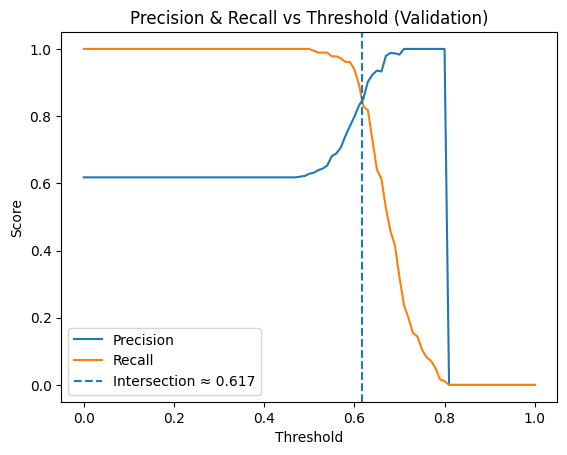

In [5]:
# 1) Compute precision & recall on a fixed grid
thresholds = np.round(np.linspace(0, 1, 101), 2)  # 0.00, 0.01, ..., 1.00
rows = []
for t in thresholds:
    y_hat = (y_val_pred >= t).astype(int)
    p = precision_score(y_val, y_hat, zero_division=0)
    r = recall_score(y_val, y_hat, zero_division=0)
    rows.append((t, p, r, p - r))

pr_df = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "diff_p_minus_r"])

# 2) Find the curve intersection:
#    Look for a sign change in (precision - recall) between adjacent thresholds and
#    linearly interpolate the exact crossing point.
crossings = []
for i in range(len(pr_df) - 1):
    x0, y0 = pr_df.loc[i,   ["threshold", "diff_p_minus_r"]]
    x1, y1 = pr_df.loc[i+1, ["threshold", "diff_p_minus_r"]]
    if y0 == 0:
        crossings.append(float(x0))  # exact on-grid
    elif y0 * y1 < 0:
        # linear interpolation to solve y=0:
        # y = y0 + (y1 - y0) * ((x - x0)/(x1 - x0))  ->  x = x0 - y0*(x1-x0)/(y1-y0)
        x_star = x0 - y0 * (x1 - x0) / (y1 - y0)
        crossings.append(float(x_star))

if crossings:
    t_intersection = float(crossings[0])  # first crossing
else:
    # Fallback: pick grid point with minimal |P-R|
    t_intersection = float(pr_df.loc[pr_df["diff_p_minus_r"].abs().idxmin(), "threshold"])

print(f"Estimated Precision=Recall intersection threshold: {t_intersection:.3f}")

# (Optional) Show a small neighborhood around the crossing
def neighborhood(df, x, k=5):
    i = (df["threshold"] - x).abs().idxmin()
    j0, j1 = max(0, i - k), min(len(df) - 1, i + k)
    return df.iloc[j0:j1+1]

print("\nNeighborhood around the intersection:")
display(neighborhood(pr_df, t_intersection, k=5))

# 3) Plot Precision & Recall curves and the intersection line
plt.figure()
plt.plot(pr_df["threshold"], pr_df["precision"], label="Precision")
plt.plot(pr_df["threshold"], pr_df["recall"], label="Recall")
plt.axvline(t_intersection, linestyle="--", label=f"Intersection ≈ {t_intersection:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation)")
plt.legend()
plt.show()

## Q4 — F1 vs Threshold (best trade‑off)

In [12]:
f1_rows = []
for t in thresholds:
    y_hat = (y_val_pred >= t).astype(int)
    f1_rows.append((t, f1_score(y_val, y_hat, zero_division=0)))

f1_df = pd.DataFrame(f1_rows, columns=["threshold", "f1"])
t_f1max = f1_df.loc[f1_df["f1"].idxmax(), "threshold"]
f1_df.head(63), t_f1max


(    threshold        f1
 0        0.00  0.763713
 1        0.01  0.763713
 2        0.02  0.763713
 3        0.03  0.763713
 4        0.04  0.763713
 ..        ...       ...
 58       0.58  0.836538
 59       0.59  0.855037
 60       0.60  0.862944
 61       0.61  0.861702
 62       0.62  0.840336
 
 [63 rows x 2 columns],
 np.float64(0.6))

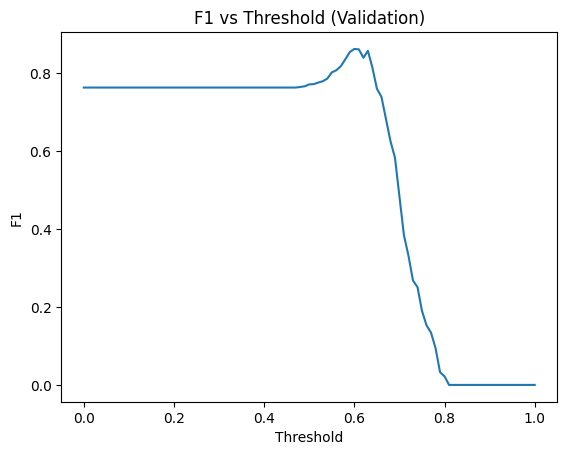

In [7]:
plt.figure()
plt.plot(f1_df["threshold"], f1_df["f1"])
plt.xlabel("Threshold"); plt.ylabel("F1"); plt.title("F1 vs Threshold (Validation)"); plt.show()

## 5) Q5 — 5‑Fold Cross‑Validation on `df_full_train`

In [8]:
def fold_auc(train_idx, val_idx):
    df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_va = df_full_train.iloc[val_idx].reset_index(drop=True)

    y_tr = df_tr[target_col].values
    y_va = df_va[target_col].values

    X_tr_df = df_tr.drop(columns=[target_col])
    X_va_df = df_va.drop(columns=[target_col])

    dv_loc = DictVectorizer(sparse=False)
    X_tr = dv_loc.fit_transform(X_tr_df.to_dict(orient="records"))
    X_va = dv_loc.transform(X_va_df.to_dict(orient="records"))

    m = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    m.fit(X_tr, y_tr)
    y_va_pred = m.predict_proba(X_va)[:, 1]
    return roc_auc_score(y_va, y_va_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = [fold_auc(tr, va) for tr, va in kf.split(df_full_train)]
print("Mean: ",np.mean(scores))
print("Stdv: ",np.std(scores))

Mean:  0.8168910142722202
Stdv:  0.029312137624452266


## 6) Q6 — Hyperparameter Tuning for `C`

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.


In [9]:

Cs = [1e-6, 1e-3, 1.0]
summary = []
for C in Cs:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for tr, va in kf.split(df_full_train):
        df_tr = df_full_train.iloc[tr].reset_index(drop=True)
        df_va = df_full_train.iloc[va].reset_index(drop=True)

        y_tr = df_tr[target_col].values
        y_va = df_va[target_col].values

        X_tr_df = df_tr.drop(columns=[target_col])
        X_va_df = df_va.drop(columns=[target_col])

        dv_loc = DictVectorizer(sparse=False)
        X_tr = dv_loc.fit_transform(X_tr_df.to_dict(orient="records"))
        X_va = dv_loc.transform(X_va_df.to_dict(orient="records"))

        m = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
        m.fit(X_tr, y_tr)
        y_va_pred = m.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, y_va_pred))
    summary.append((C, np.mean(scores), np.std(scores)))

hp = pd.DataFrame(summary, columns=["C", "mean_auc", "std_auc"]).sort_values(by=["mean_auc", "std_auc", "C"], ascending=[False, True, True])
hp


,C,mean_auc,std_auc
1,0.001000,0.860087,0.025650
2,1.000000,0.816891,0.029312
0,0.000001,0.560858,0.035122
